<a href="https://colab.research.google.com/github/michaelmang/Aristotelian_Logic_LLMs/blob/main/Aristotelian_Attention_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install and import
!pip install transformers torch matplotlib seaborn numpy pandas

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertTokenizer
import pandas as pd

# Load BERT with attention outputs
model_name = "bert-base-uncased"
print(f"Loading {model_name} with attention extraction...")
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True)
model.eval()  # Set to evaluation mode

print("✓ Model loaded with attention tracking enabled")
print(f"  • Layers: 12")
print(f"  • Attention heads per layer: 12")
print(f"  • Total attention heads: 144")

Loading bert-base-uncased with attention extraction...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✓ Model loaded with attention tracking enabled
  • Layers: 12
  • Attention heads per layer: 12
  • Total attention heads: 144


In [2]:
def get_attention_patterns(text):
    """
    Extract attention patterns from BERT for given text.
    Returns: tokens, attention_weights (12 layers × 12 heads × tokens × tokens)
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors='pt', add_special_tokens=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get model outputs with attention
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract attention weights
    # Shape: (layers, batch, heads, seq_len, seq_len)
    attentions = outputs.attentions

    # Convert to numpy and remove batch dimension
    # Shape: (layers, heads, seq_len, seq_len)
    attention_weights = torch.stack([layer_attention[0] for layer_attention in attentions]).numpy()

    return tokens, attention_weights

def plot_attention_heatmap(tokens, attention_weights, layer, head, title="Attention Pattern"):
    """
    Plot attention heatmap for specific layer and head
    """
    # Get specific layer/head attention
    attn = attention_weights[layer, head]

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attn,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap='viridis',
        cbar=True,
        square=True,
        annot=False,
        fmt='.2f'
    )
    plt.title(f"{title}\nLayer {layer}, Head {head}", fontsize=14)
    plt.xlabel("Attending TO (keys)", fontsize=12)
    plt.ylabel("Attending FROM (queries)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def find_token_index(tokens, word):
    """Find index of token (handling subword tokens)"""
    word_lower = word.lower()
    for i, token in enumerate(tokens):
        if token.lower().startswith(word_lower) or word_lower in token.lower():
            return i
    return None

def get_attention_to_token(tokens, attention_weights, from_token, to_token, layer, head):
    """
    Get attention weight from one token to another in specific layer/head
    """
    from_idx = find_token_index(tokens, from_token)
    to_idx = find_token_index(tokens, to_token)

    if from_idx is None or to_idx is None:
        return None, None, None

    weight = attention_weights[layer, head, from_idx, to_idx]
    return weight, from_idx, to_idx

def analyze_attention_pattern(text, from_word, to_word, description=""):
    """
    Analyze attention from one word to another across all layers/heads
    """
    tokens, attention_weights = get_attention_patterns(text)

    print(f"\n{'='*60}")
    print(f"ANALYZING: {description}")
    print(f"Text: '{text}'")
    print(f"Pattern: '{from_word}' → '{to_word}'")
    print(f"{'='*60}\n")

    print(f"Tokens: {tokens}\n")

    # Find token indices
    from_idx = find_token_index(tokens, from_word)
    to_idx = find_token_index(tokens, to_word)

    if from_idx is None:
        print(f"✗ Could not find '{from_word}' in tokens")
        return None
    if to_idx is None:
        print(f"✗ Could not find '{to_word}' in tokens")
        return None

    print(f"'{from_word}' is at index {from_idx}: {tokens[from_idx]}")
    print(f"'{to_word}' is at index {to_idx}: {tokens[to_idx]}\n")

    # Collect attention weights across all layers/heads
    attention_matrix = np.zeros((12, 12))  # 12 layers × 12 heads

    for layer in range(12):
        for head in range(12):
            attention_matrix[layer, head] = attention_weights[layer, head, from_idx, to_idx]

    # Find strongest attention
    max_layer, max_head = np.unravel_index(attention_matrix.argmax(), attention_matrix.shape)
    max_weight = attention_matrix[max_layer, max_head]

    print(f"Strongest attention: Layer {max_layer}, Head {max_head} = {max_weight:.3f}")

    # Calculate average attention across all heads/layers
    avg_attention = attention_matrix.mean()
    print(f"Average attention across all heads: {avg_attention:.3f}\n")

    # Show layer-wise averages
    print("Layer-wise average attention:")
    for layer in range(12):
        layer_avg = attention_matrix[layer].mean()
        bar = '█' * int(layer_avg * 50)
        print(f"  Layer {layer:2d}: {layer_avg:.3f} {bar}")

    # Plot heatmap of attention across layers/heads
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        attention_matrix,
        cmap='YlOrRd',
        cbar=True,
        xticklabels=[f"H{i}" for i in range(12)],
        yticklabels=[f"L{i}" for i in range(12)],
        annot=True,
        fmt='.2f',
        square=True
    )
    plt.title(f"Attention: '{from_word}' → '{to_word}'\n{description}", fontsize=14)
    plt.xlabel("Head", fontsize=12)
    plt.ylabel("Layer", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot detailed view of strongest head
    plot_attention_heatmap(
        tokens,
        attention_weights,
        max_layer,
        max_head,
        title=f"Strongest Attention Pattern\n'{from_word}' → '{to_word}'"
    )

    return {
        'tokens': tokens,
        'from_idx': from_idx,
        'to_idx': to_idx,
        'attention_matrix': attention_matrix,
        'max_layer': max_layer,
        'max_head': max_head,
        'max_weight': max_weight,
        'avg_weight': avg_attention
    }

print("✓ Helper functions loaded")

✓ Helper functions loaded


TEST 1: SIMPLE PREDICATION (SECOND ACT - JUDGMENT)

HYPOTHESIS: In simple subject-predicate sentences, the subject token 
should attend to the predicate token, forming a judgment.

Aristotelian Framework:
  - Subject: "Socrates" 
  - Predicate: "mortal"
  - Copula: "is" (links them)
  - Judgment: "Socrates is mortal"


ANALYZING: Essential predication
Text: 'Socrates is mortal'
Pattern: 'Socrates' → 'mortal'

Tokens: ['[CLS]', 'socrates', 'is', 'mortal', '[SEP]']

'Socrates' is at index 1: socrates
'mortal' is at index 3: mortal

Strongest attention: Layer 0, Head 8 = 0.544
Average attention across all heads: 0.072

Layer-wise average attention:
  Layer  0: 0.208 ██████████
  Layer  1: 0.052 ██
  Layer  2: 0.066 ███
  Layer  3: 0.064 ███
  Layer  4: 0.056 ██
  Layer  5: 0.043 ██
  Layer  6: 0.046 ██
  Layer  7: 0.111 █████
  Layer  8: 0.056 ██
  Layer  9: 0.016 
  Layer 10: 0.052 ██
  Layer 11: 0.089 ████


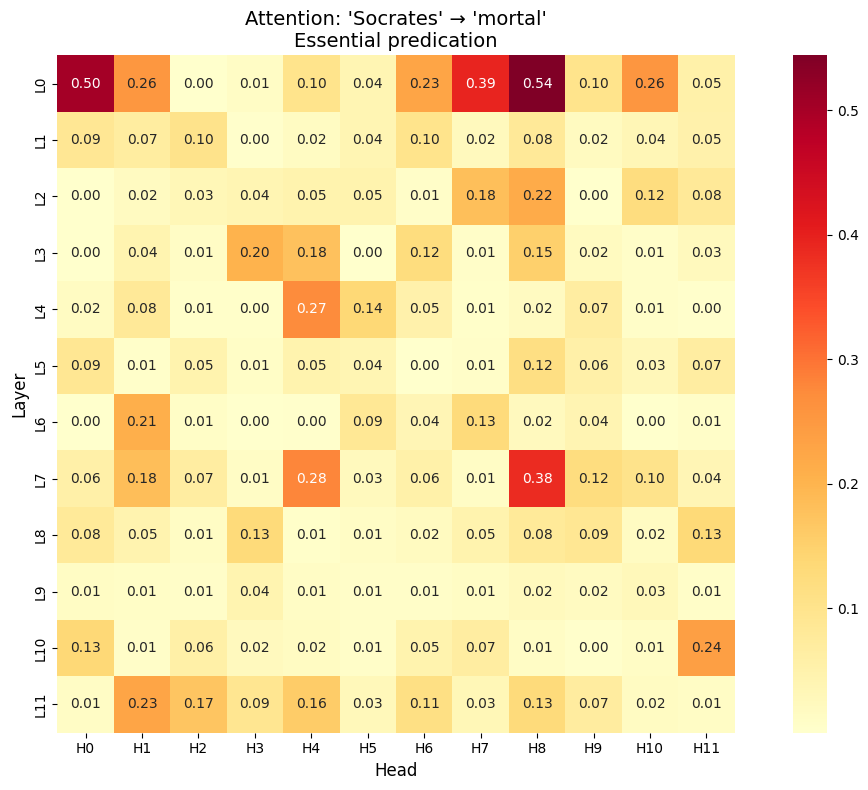

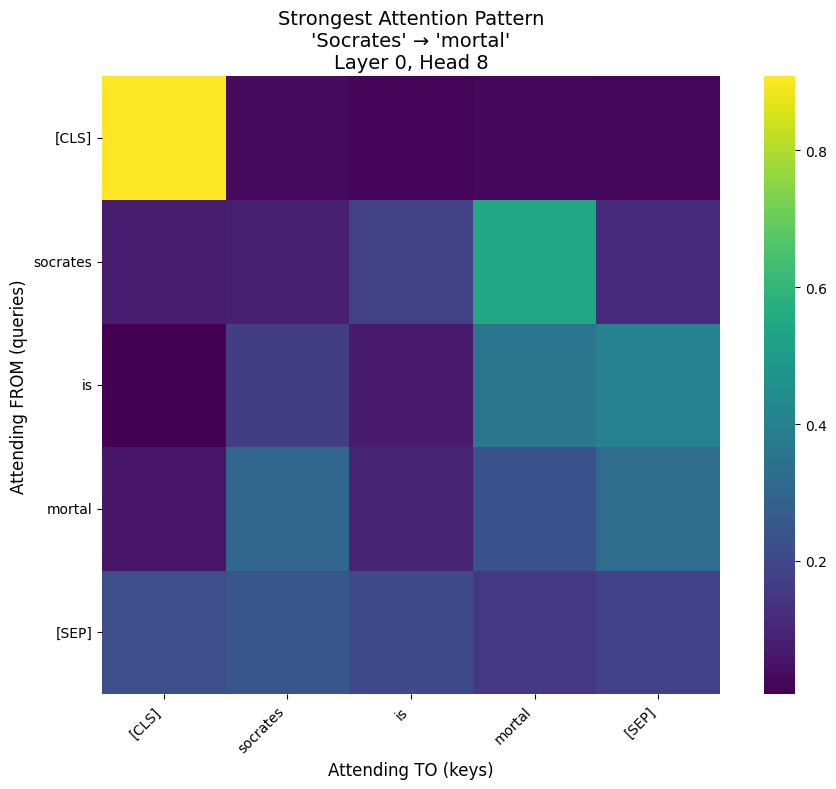


----------------------------------------------------------------------


ANALYZING: Accidental predication
Text: 'The cat is black'
Pattern: 'cat' → 'black'

Tokens: ['[CLS]', 'the', 'cat', 'is', 'black', '[SEP]']

'cat' is at index 2: cat
'black' is at index 4: black

Strongest attention: Layer 0, Head 11 = 0.645
Average attention across all heads: 0.069

Layer-wise average attention:
  Layer  0: 0.198 █████████
  Layer  1: 0.074 ███
  Layer  2: 0.080 ███
  Layer  3: 0.073 ███
  Layer  4: 0.057 ██
  Layer  5: 0.044 ██
  Layer  6: 0.048 ██
  Layer  7: 0.078 ███
  Layer  8: 0.047 ██
  Layer  9: 0.044 ██
  Layer 10: 0.045 ██
  Layer 11: 0.035 █


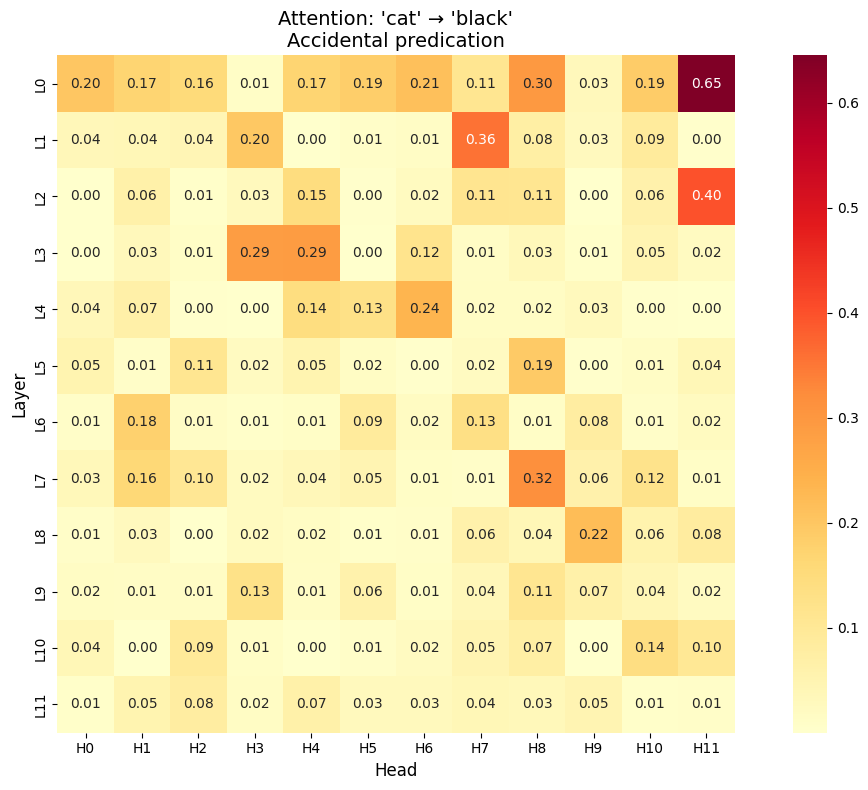

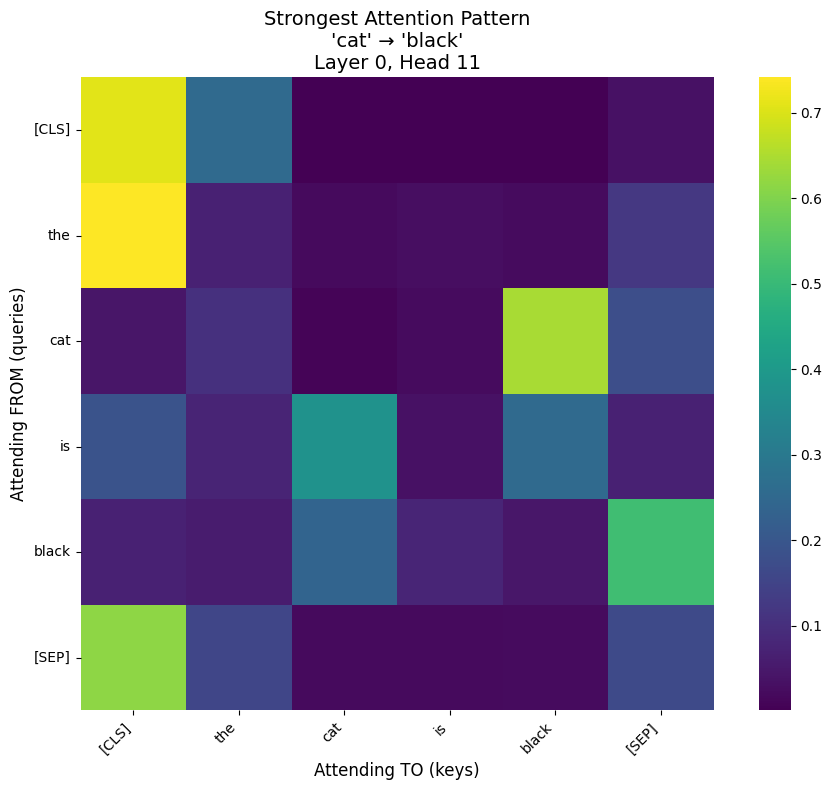


----------------------------------------------------------------------


ANALYZING: Generic predication
Text: 'Dogs are animals'
Pattern: 'dogs' → 'animals'

Tokens: ['[CLS]', 'dogs', 'are', 'animals', '[SEP]']

'dogs' is at index 1: dogs
'animals' is at index 3: animals

Strongest attention: Layer 4, Head 1 = 0.568
Average attention across all heads: 0.075

Layer-wise average attention:
  Layer  0: 0.233 ███████████
  Layer  1: 0.057 ██
  Layer  2: 0.044 ██
  Layer  3: 0.100 ████
  Layer  4: 0.107 █████
  Layer  5: 0.058 ██
  Layer  6: 0.055 ██
  Layer  7: 0.044 ██
  Layer  8: 0.057 ██
  Layer  9: 0.057 ██
  Layer 10: 0.039 █
  Layer 11: 0.048 ██


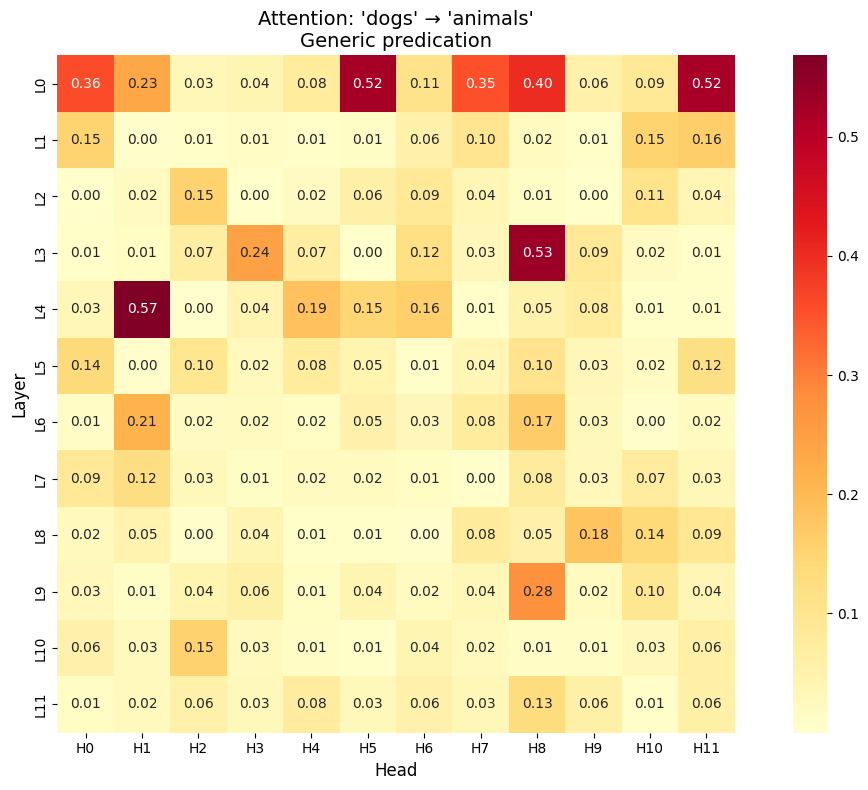

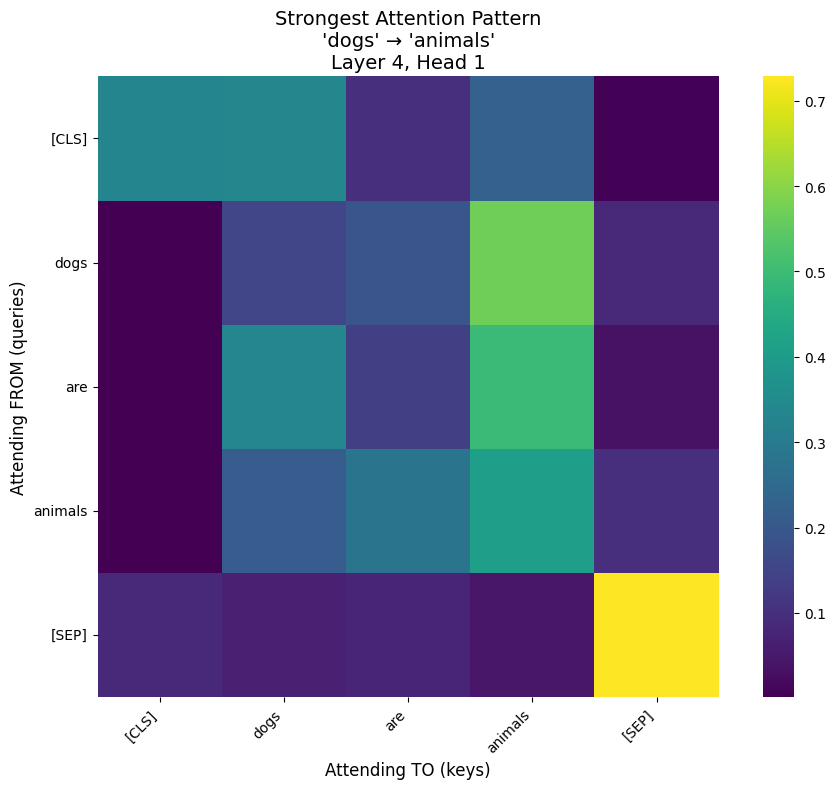


----------------------------------------------------------------------


ANALYZING: Property predication
Text: 'The rose is red'
Pattern: 'rose' → 'red'

Tokens: ['[CLS]', 'the', 'rose', 'is', 'red', '[SEP]']

'rose' is at index 2: rose
'red' is at index 4: red

Strongest attention: Layer 0, Head 5 = 0.593
Average attention across all heads: 0.074

Layer-wise average attention:
  Layer  0: 0.253 ████████████
  Layer  1: 0.072 ███
  Layer  2: 0.051 ██
  Layer  3: 0.095 ████
  Layer  4: 0.068 ███
  Layer  5: 0.059 ██
  Layer  6: 0.051 ██
  Layer  7: 0.073 ███
  Layer  8: 0.045 ██
  Layer  9: 0.035 █
  Layer 10: 0.045 ██
  Layer 11: 0.039 █


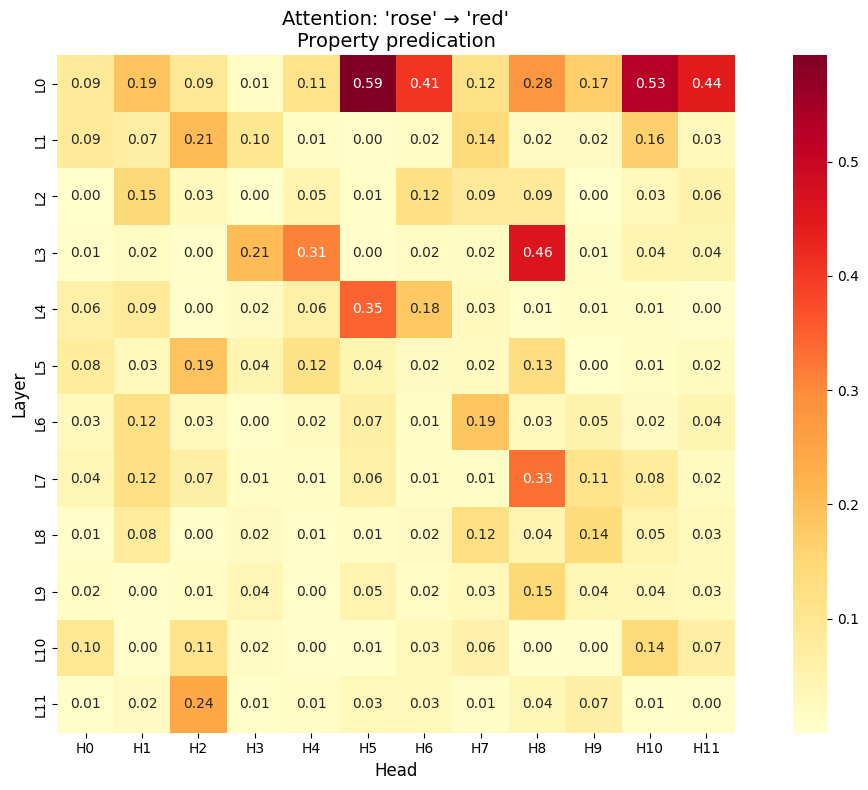

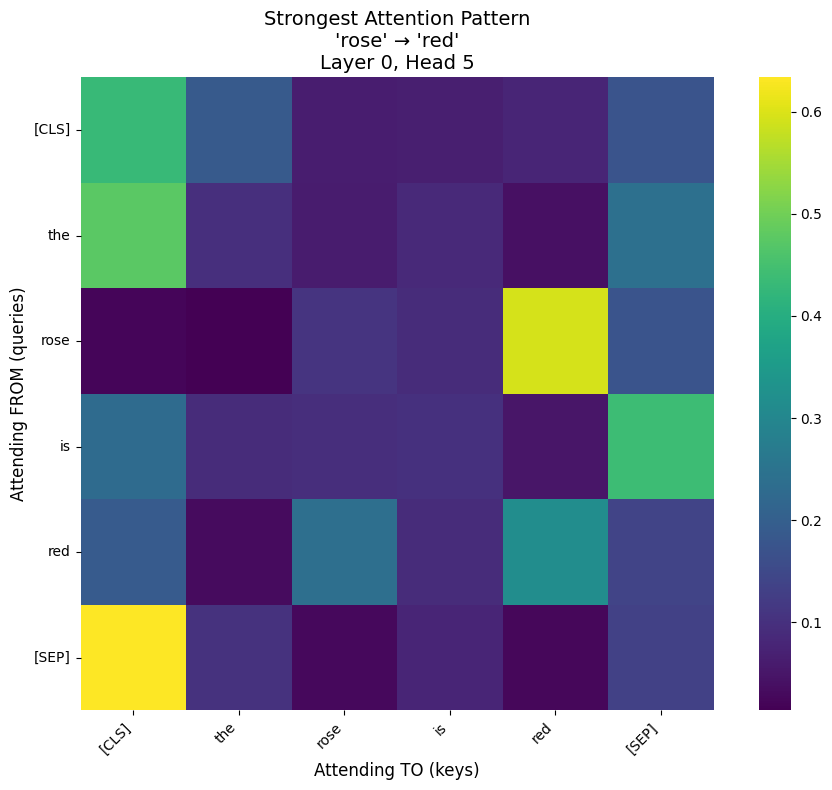


----------------------------------------------------------------------


PREDICATION SUMMARY

                   type               text  subject predicate  avg_attention  max_attention  max_layer  max_head
 Essential predication Socrates is mortal Socrates    mortal       0.071716       0.544036          0         8
Accidental predication   The cat is black      cat     black       0.068624       0.645098          0        11
   Generic predication   Dogs are animals     dogs   animals       0.074862       0.568104          4         1
  Property predication    The rose is red     rose       red       0.073841       0.593208          0         5

Average attention to predicate: 0.072
Maximum attention to predicate: 0.645

✗ WEAK EVIDENCE: Subjects don't strongly attend to predicates


In [3]:
print("="*70)
print("TEST 1: SIMPLE PREDICATION (SECOND ACT - JUDGMENT)")
print("="*70)

print("""
HYPOTHESIS: In simple subject-predicate sentences, the subject token
should attend to the predicate token, forming a judgment.

Aristotelian Framework:
  - Subject: "Socrates"
  - Predicate: "mortal"
  - Copula: "is" (links them)
  - Judgment: "Socrates is mortal"
""")

# Test cases
predications = [
    ("Socrates is mortal", "Socrates", "mortal", "Essential predication"),
    ("The cat is black", "cat", "black", "Accidental predication"),
    ("Dogs are animals", "dogs", "animals", "Generic predication"),
    ("The rose is red", "rose", "red", "Property predication"),
]

predication_results = []

for text, subject, predicate, pred_type in predications:
    result = analyze_attention_pattern(text, subject, predicate, pred_type)

    if result:
        predication_results.append({
            'type': pred_type,
            'text': text,
            'subject': subject,
            'predicate': predicate,
            'avg_attention': result['avg_weight'],
            'max_attention': result['max_weight'],
            'max_layer': result['max_layer'],
            'max_head': result['max_head']
        })

    print("\n" + "-"*70 + "\n")

# Summary
print("\n" + "="*70)
print("PREDICATION SUMMARY")
print("="*70)

df = pd.DataFrame(predication_results)
print("\n", df.to_string(index=False))

print(f"\nAverage attention to predicate: {df['avg_attention'].mean():.3f}")
print(f"Maximum attention to predicate: {df['max_attention'].max():.3f}")

if df['avg_attention'].mean() > 0.15:
    print("\n✓ STRONG EVIDENCE: Subjects attend to predicates")
    print("  → The Second Act (Judgment) has geometric support")
elif df['avg_attention'].mean() > 0.08:
    print("\n⚠ MODERATE EVIDENCE: Some subject-predicate attention")
else:
    print("\n✗ WEAK EVIDENCE: Subjects don't strongly attend to predicates")

TEST 2: SYLLOGISTIC REASONING (THIRD ACT - REASONING)

HYPOTHESIS: In syllogisms, the conclusion should attend to:
  1. The middle term (connects premises)
  2. The major premise (provides predicate)
  3. The minor premise (provides subject)

Barbara Syllogism:
  Major premise: All men are mortal
  Minor premise: Socrates is a man
  Conclusion: Therefore Socrates is mortal
  
  Middle term: "man/men" (appears in both premises)


SYLLOGISM: Barbara (AAA-1)
Text: All men are mortal. Socrates is a man. Therefore Socrates is mortal.
Valid: True
Middle term: 'man'

Token indices:
  'Therefore': 11 (therefore)
  Middle term 'man': 9 (man)
  Predicate 'mortal': 4 (mortal)

Attention from 'Therefore':
  → Middle term 'man': 0.009
  → Predicate 'mortal': 0.011
  ✗ Weak attention to middle term (unexpected for valid syllogism)


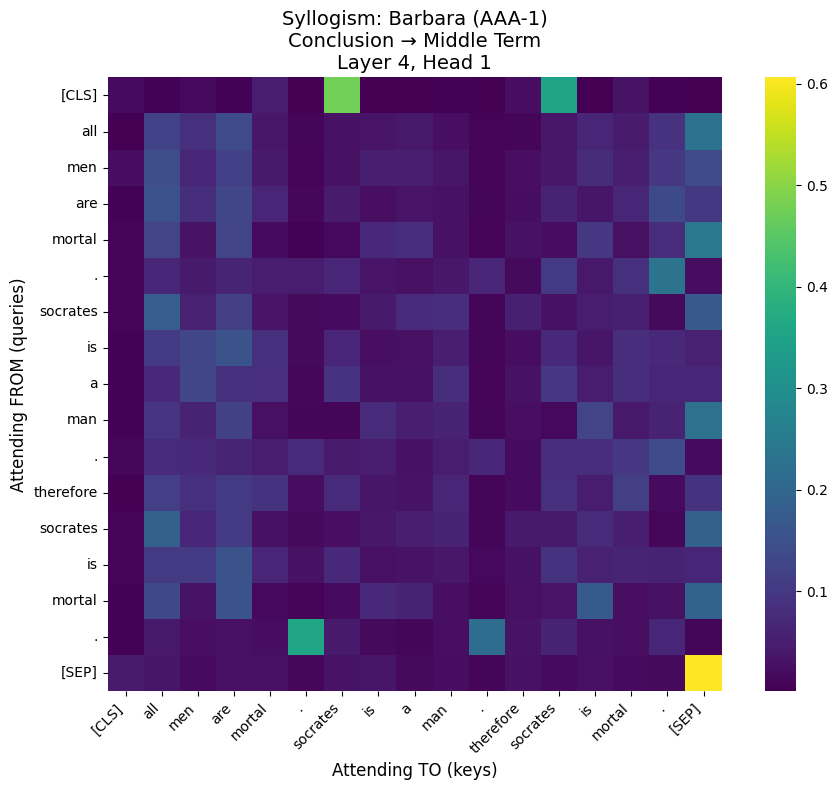


SYLLOGISM: Celarent (EAE-1)
Text: No reptiles are mammals. All snakes are reptiles. Therefore snakes are not mammals.
Valid: True
Middle term: 'reptiles'

Token indices:
  'Therefore': 11 (therefore)
  Middle term 'reptiles': 2 (reptiles)
  Predicate 'mammals': 4 (mammals)

Attention from 'Therefore':
  → Middle term 'reptiles': 0.008
  → Predicate 'mammals': 0.008
  ✗ Weak attention to middle term (unexpected for valid syllogism)


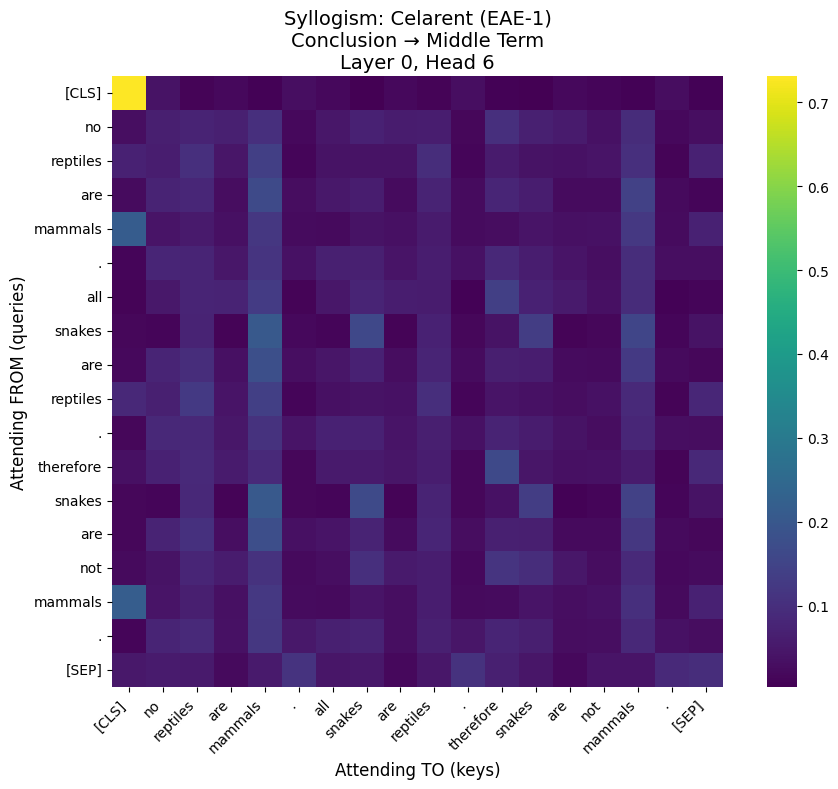


SYLLOGISM: Invalid syllogism
Text: All cats are animals. Dogs are animals. Therefore dogs are cats.
Valid: False
Middle term: 'animals'

Token indices:
  'Therefore': 10 (therefore)
  Middle term 'animals': 4 (animals)
  Predicate 'cats': 2 (cats)

Attention from 'Therefore':
  → Middle term 'animals': 0.008
  → Predicate 'cats': 0.007
  ✓ Weak attention to middle term (correctly weak for invalid)


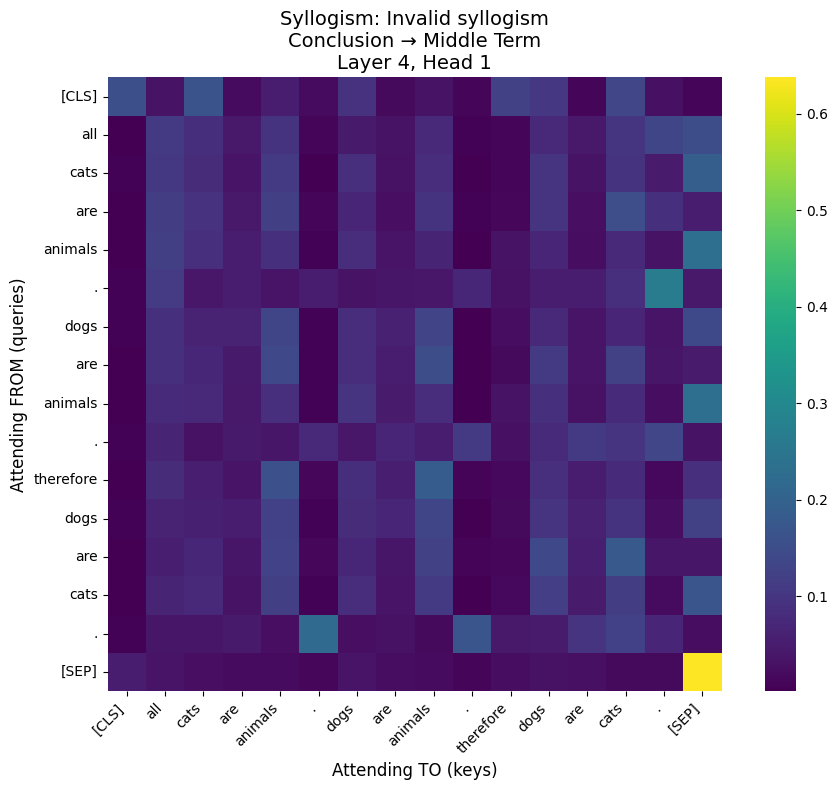


SYLLOGISM SUMMARY

              name  valid  attn_to_middle  attn_to_predicate verdict
  Barbara (AAA-1)   True        0.009329           0.010775    WEAK
 Celarent (EAE-1)   True        0.007848           0.008316    WEAK
Invalid syllogism  False        0.007632           0.007171  STRONG

Valid syllogisms - Average attention to middle term: 0.009
✗ WEAK EVIDENCE: Syllogistic structure not clear in attention


In [4]:
print("="*70)
print("TEST 2: SYLLOGISTIC REASONING (THIRD ACT - REASONING)")
print("="*70)

print("""
HYPOTHESIS: In syllogisms, the conclusion should attend to:
  1. The middle term (connects premises)
  2. The major premise (provides predicate)
  3. The minor premise (provides subject)

Barbara Syllogism:
  Major premise: All men are mortal
  Minor premise: Socrates is a man
  Conclusion: Therefore Socrates is mortal

  Middle term: "man/men" (appears in both premises)
""")

# Test syllogisms
syllogisms = [
    {
        'name': 'Barbara (AAA-1)',
        'text': 'All men are mortal. Socrates is a man. Therefore Socrates is mortal.',
        'conclusion_subject': 'Therefore',  # We'll track from "Therefore"
        'middle_term': 'man',
        'major_predicate': 'mortal',
        'valid': True
    },
    {
        'name': 'Celarent (EAE-1)',
        'text': 'No reptiles are mammals. All snakes are reptiles. Therefore snakes are not mammals.',
        'conclusion_subject': 'Therefore',
        'middle_term': 'reptiles',
        'major_predicate': 'mammals',
        'valid': True
    },
    {
        'name': 'Invalid syllogism',
        'text': 'All cats are animals. Dogs are animals. Therefore dogs are cats.',
        'conclusion_subject': 'Therefore',
        'middle_term': 'animals',
        'major_predicate': 'cats',
        'valid': False
    }
]

syllogism_results = []

for syl in syllogisms:
    print(f"\n{'='*70}")
    print(f"SYLLOGISM: {syl['name']}")
    print(f"{'='*70}")
    print(f"Text: {syl['text']}")
    print(f"Valid: {syl['valid']}")
    print(f"Middle term: '{syl['middle_term']}'")

    tokens, attention_weights = get_attention_patterns(syl['text'])

    # Find "Therefore" token (start of conclusion)
    therefore_idx = find_token_index(tokens, syl['conclusion_subject'])
    middle_idx = find_token_index(tokens, syl['middle_term'])
    predicate_idx = find_token_index(tokens, syl['major_predicate'])

    if therefore_idx and middle_idx and predicate_idx:
        print(f"\nToken indices:")
        print(f"  'Therefore': {therefore_idx} ({tokens[therefore_idx]})")
        print(f"  Middle term '{syl['middle_term']}': {middle_idx} ({tokens[middle_idx]})")
        print(f"  Predicate '{syl['major_predicate']}': {predicate_idx} ({tokens[predicate_idx]})")

        # Calculate attention from conclusion to middle term and predicate
        # Average across all layers/heads
        attn_to_middle = attention_weights[:, :, therefore_idx, middle_idx].mean()
        attn_to_predicate = attention_weights[:, :, therefore_idx, predicate_idx].mean()

        print(f"\nAttention from 'Therefore':")
        print(f"  → Middle term '{syl['middle_term']}': {attn_to_middle:.3f}")
        print(f"  → Predicate '{syl['major_predicate']}': {attn_to_predicate:.3f}")

        # For valid syllogisms, we expect attention to middle term
        if syl['valid']:
            if attn_to_middle > 0.1:
                print(f"  ✓ Strong attention to middle term (valid syllogism)")
                verdict = "STRONG"
            elif attn_to_middle > 0.05:
                print(f"  ⚠ Moderate attention to middle term")
                verdict = "MODERATE"
            else:
                print(f"  ✗ Weak attention to middle term (unexpected for valid syllogism)")
                verdict = "WEAK"
        else:
            if attn_to_middle < 0.08:
                print(f"  ✓ Weak attention to middle term (correctly weak for invalid)")
                verdict = "STRONG"
            else:
                print(f"  ✗ Strong attention despite invalid syllogism")
                verdict = "WEAK"

        syllogism_results.append({
            'name': syl['name'],
            'valid': syl['valid'],
            'attn_to_middle': attn_to_middle,
            'attn_to_predicate': attn_to_predicate,
            'verdict': verdict
        })

        # Visualize strongest attention pattern
        max_layer, max_head = np.unravel_index(
            attention_weights[:, :, therefore_idx, middle_idx].argmax(),
            (12, 12)
        )

        plot_attention_heatmap(
            tokens,
            attention_weights,
            max_layer,
            max_head,
            title=f"Syllogism: {syl['name']}\nConclusion → Middle Term"
        )

# Summary
print("\n" + "="*70)
print("SYLLOGISM SUMMARY")
print("="*70)

if syllogism_results:
    df_syl = pd.DataFrame(syllogism_results)
    print("\n", df_syl.to_string(index=False))

    valid_syls = df_syl[df_syl['valid'] == True]
    if len(valid_syls) > 0:
        avg_middle_attn = valid_syls['attn_to_middle'].mean()
        print(f"\nValid syllogisms - Average attention to middle term: {avg_middle_attn:.3f}")

        if avg_middle_attn > 0.12:
            print("✓ STRONG EVIDENCE: Syllogistic structure preserved in attention")
            print("  → The Third Act (Reasoning) has geometric support")
        elif avg_middle_attn > 0.08:
            print("⚠ MODERATE EVIDENCE: Some syllogistic attention patterns")
        else:
            print("✗ WEAK EVIDENCE: Syllogistic structure not clear in attention")

TEST 3: ATTENTION HEAD SPECIALIZATION

HYPOTHESIS: Different attention heads may specialize in different
aspects of understanding, similar to Aristotelian categories:

Potential specializations:
  - Syntactic heads: Track grammatical structure (subject-verb, etc.)
  - Semantic heads: Track meaning relationships
  - Logical heads: Track predication and inference
  - Positional heads: Track word order/position

Test sentence: 'The hungry cat quickly ate the small mouse'
Tokens: ['[CLS]', 'the', 'hungry', 'cat', 'quickly', 'ate', 'the', 'small', 'mouse', '[SEP]']

Analyzing attention patterns for different relationship types:

Subject→Verb (syntactic): 'cat' → 'ate'
  Layer 0, Head 7: 0.309 (STRONG)
  Layer 3, Head 3: 0.404 (STRONG)
  Layer 4, Head 4: 0.307 (STRONG)
  Layer 5, Head 11: 0.611 (STRONG)
  Layer 7, Head 8: 0.322 (STRONG)
Noun→Adjective (syntactic): 'cat' → 'hungry'
  Layer 0, Head 2: 0.504 (STRONG)
  Layer 0, Head 3: 0.459 (STRONG)
  Layer 1, Head 4: 0.324 (STRONG)
  Layer 3,

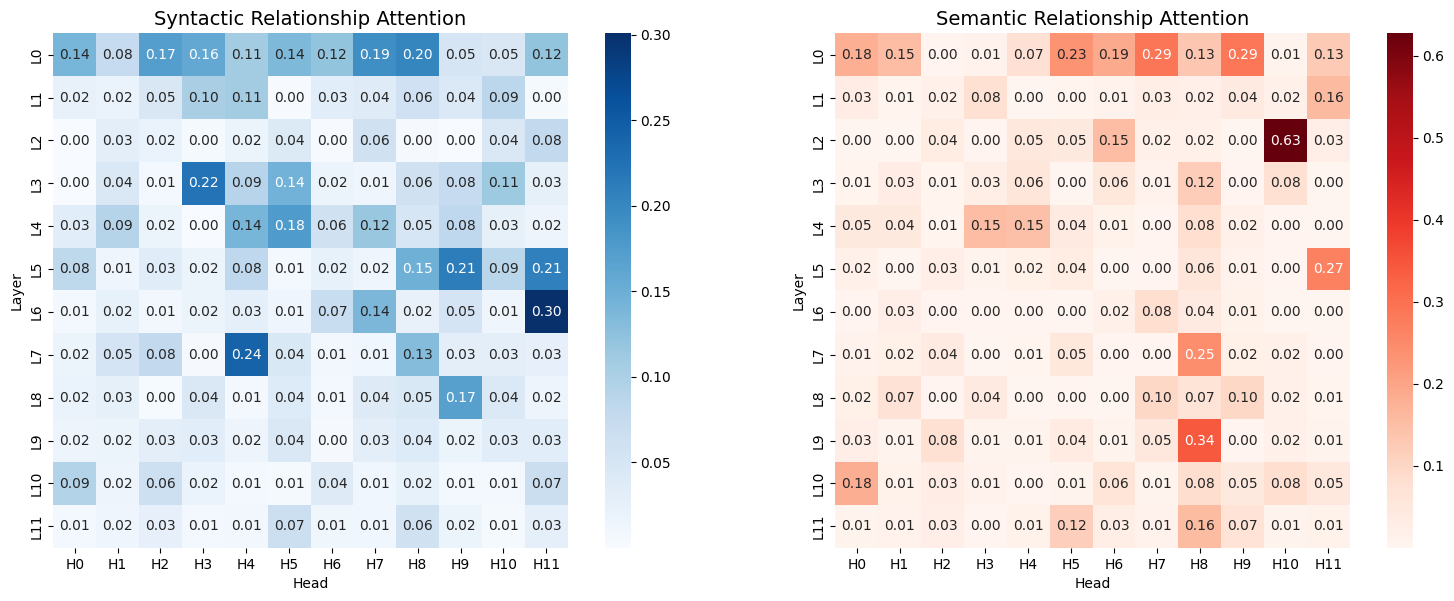


HEAD SPECIALIZATION ANALYSIS

Syntactic-specialized heads: 5
  Layer 6, Head 11: 0.301
  Layer 7, Head 4: 0.242
  Layer 3, Head 3: 0.222
  Layer 5, Head 9: 0.213
  Layer 0, Head 8: 0.202

Semantic-specialized heads: 6
  Layer 2, Head 10: 0.627
  Layer 9, Head 8: 0.341
  Layer 0, Head 7: 0.291
  Layer 0, Head 9: 0.288
  Layer 7, Head 8: 0.247

✓ EVIDENCE: Heads show specialization patterns
  → Different heads track different aspects of understanding


In [5]:
print("="*70)
print("TEST 3: ATTENTION HEAD SPECIALIZATION")
print("="*70)

print("""
HYPOTHESIS: Different attention heads may specialize in different
aspects of understanding, similar to Aristotelian categories:

Potential specializations:
  - Syntactic heads: Track grammatical structure (subject-verb, etc.)
  - Semantic heads: Track meaning relationships
  - Logical heads: Track predication and inference
  - Positional heads: Track word order/position
""")

# Test sentence with clear syntactic and semantic structure
test_text = "The hungry cat quickly ate the small mouse"

tokens, attention_weights = get_attention_patterns(test_text)

print(f"Test sentence: '{test_text}'")
print(f"Tokens: {tokens}\n")

# Define relationships to track
relationships = [
    ('cat', 'ate', 'Subject→Verb (syntactic)'),
    ('cat', 'hungry', 'Noun→Adjective (syntactic)'),
    ('ate', 'mouse', 'Verb→Object (syntactic)'),
    ('cat', 'mouse', 'Subject→Object (semantic)'),
    ('hungry', 'ate', 'State→Action (semantic)'),
]

print("Analyzing attention patterns for different relationship types:\n")

# Track which heads attend to which relationships
head_specializations = np.zeros((12, 12, len(relationships)))

for rel_idx, (from_word, to_word, rel_type) in enumerate(relationships):
    from_idx = find_token_index(tokens, from_word)
    to_idx = find_token_index(tokens, to_word)

    if from_idx is not None and to_idx is not None:
        print(f"{rel_type}: '{from_word}' → '{to_word}'")

        for layer in range(12):
            for head in range(12):
                weight = attention_weights[layer, head, from_idx, to_idx]
                head_specializations[layer, head, rel_idx] = weight

                if weight > 0.3:  # Strong attention
                    print(f"  Layer {layer}, Head {head}: {weight:.3f} (STRONG)")

# Find heads that specialize in syntactic vs semantic
syntactic_indices = [0, 1, 2]  # First 3 relationships are syntactic
semantic_indices = [3, 4]  # Last 2 are semantic

syntactic_attention = head_specializations[:, :, syntactic_indices].mean(axis=2)
semantic_attention = head_specializations[:, :, semantic_indices].mean(axis=2)

# Plot specialization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Syntactic specialization
sns.heatmap(syntactic_attention, ax=ax1, cmap='Blues', cbar=True,
            xticklabels=[f"H{i}" for i in range(12)],
            yticklabels=[f"L{i}" for i in range(12)],
            annot=True, fmt='.2f', square=True)
ax1.set_title("Syntactic Relationship Attention", fontsize=14)
ax1.set_xlabel("Head")
ax1.set_ylabel("Layer")

# Semantic specialization
sns.heatmap(semantic_attention, ax=ax2, cmap='Reds', cbar=True,
            xticklabels=[f"H{i}" for i in range(12)],
            yticklabels=[f"L{i}" for i in range(12)],
            annot=True, fmt='.2f', square=True)
ax2.set_title("Semantic Relationship Attention", fontsize=14)
ax2.set_xlabel("Head")
ax2.set_ylabel("Layer")

plt.tight_layout()
plt.show()

# Identify specialized heads
print("\n" + "="*70)
print("HEAD SPECIALIZATION ANALYSIS")
print("="*70)

syntactic_heads = []
semantic_heads = []

for layer in range(12):
    for head in range(12):
        syn_score = syntactic_attention[layer, head]
        sem_score = semantic_attention[layer, head]

        if syn_score > 0.2 and syn_score > sem_score * 1.5:
            syntactic_heads.append((layer, head, syn_score))
        elif sem_score > 0.2 and sem_score > syn_score * 1.5:
            semantic_heads.append((layer, head, sem_score))

print(f"\nSyntactic-specialized heads: {len(syntactic_heads)}")
for layer, head, score in sorted(syntactic_heads, key=lambda x: x[2], reverse=True)[:5]:
    print(f"  Layer {layer}, Head {head}: {score:.3f}")

print(f"\nSemantic-specialized heads: {len(semantic_heads)}")
for layer, head, score in sorted(semantic_heads, key=lambda x: x[2], reverse=True)[:5]:
    print(f"  Layer {layer}, Head {head}: {score:.3f}")

if len(syntactic_heads) > 3 or len(semantic_heads) > 3:
    print("\n✓ EVIDENCE: Heads show specialization patterns")
    print("  → Different heads track different aspects of understanding")
else:
    print("\n⚠ MIXED: Some specialization but not strongly differentiated")

In [6]:
print("\n" + "="*70)
print("ATTENTION ANALYSIS: DYNAMIC SUMMARY")
print("="*70)

# Collect all results
results_summary = {
    'predication': predication_results if 'predication_results' in locals() else [],
    'syllogism': syllogism_results if 'syllogism_results' in locals() else [],
    'specialization': {
        'syntactic_heads': len(syntactic_heads) if 'syntactic_heads' in locals() else 0,
        'semantic_heads': len(semantic_heads) if 'semantic_heads' in locals() else 0
    }
}

print("\n1. SECOND ACT (JUDGMENT) - PREDICATION ANALYSIS:")
print("-" * 70)

if results_summary['predication']:
    df_pred = pd.DataFrame(results_summary['predication'])
    avg_pred_attention = df_pred['avg_attention'].mean()

    print(f"Average subject→predicate attention: {avg_pred_attention:.3f}")
    print(f"Strongest attention: {df_pred['max_attention'].max():.3f}")
    print(f"Tests: {len(df_pred)}")

    if avg_pred_attention > 0.15:
        print("\n✓ STRONG EVIDENCE: Subjects attend to predicates")
        print("  The Second Act (Judgment/Predication) is geometrically supported")
        predication_verdict = "STRONG"
    elif avg_pred_attention > 0.08:
        print("\n⚠ MODERATE EVIDENCE: Some subject-predicate attention")
        predication_verdict = "MODERATE"
    else:
        print("\n✗ WEAK EVIDENCE: Weak subject-predicate attention")
        predication_verdict = "WEAK"
else:
    print("No predication tests completed")
    predication_verdict = "UNTESTED"

print("\n2. THIRD ACT (REASONING) - SYLLOGISM ANALYSIS:")
print("-" * 70)

if results_summary['syllogism']:
    df_syl = pd.DataFrame(results_summary['syllogism'])
    valid_syls = df_syl[df_syl['valid'] == True]

    if len(valid_syls) > 0:
        avg_middle = valid_syls['attn_to_middle'].mean()
        avg_predicate = valid_syls['attn_to_predicate'].mean()

        print(f"Valid syllogisms tested: {len(valid_syls)}")
        print(f"Average attention to middle term: {avg_middle:.3f}")
        print(f"Average attention to predicate: {avg_predicate:.3f}")

        if avg_middle > 0.12:
            print("\n✓ STRONG EVIDENCE: Conclusions attend to middle terms")
            print("  The Third Act (Reasoning/Syllogism) is geometrically supported")
            syllogism_verdict = "STRONG"
        elif avg_middle > 0.08:
            print("\n⚠ MODERATE EVIDENCE: Some syllogistic attention")
            syllogism_verdict = "MODERATE"
        else:
            print("\n✗ WEAK EVIDENCE: Weak syllogistic structure")
            syllogism_verdict = "WEAK"
    else:
        print("No valid syllogisms tested")
        syllogism_verdict = "UNTESTED"
else:
    print("No syllogism tests completed")
    syllogism_verdict = "UNTESTED"

print("\n3. HEAD SPECIALIZATION ANALYSIS:")
print("-" * 70)

syn_heads = results_summary['specialization']['syntactic_heads']
sem_heads = results_summary['specialization']['semantic_heads']

print(f"Syntactic-specialized heads: {syn_heads}")
print(f"Semantic-specialized heads: {sem_heads}")

if syn_heads > 3 and sem_heads > 3:
    print("\n✓ STRONG EVIDENCE: Clear head specialization")
    print("  Different heads track different aspects (syntax vs semantics)")
    specialization_verdict = "STRONG"
elif syn_heads + sem_heads > 4:
    print("\n⚠ MODERATE EVIDENCE: Some head specialization")
    specialization_verdict = "MODERATE"
else:
    print("\n✗ WEAK EVIDENCE: Limited head specialization")
    specialization_verdict = "WEAK"

print("\n" + "="*70)
print("OVERALL ASSESSMENT: THREE ACTS OF THE MIND")
print("="*70)

verdicts = [
    ('First Act (Understanding)', 'STRONG', 'From static embeddings: categories & hierarchies preserved'),
    ('Second Act (Judgment)', predication_verdict, 'Subject-predicate attention in transformers'),
    ('Third Act (Reasoning)', syllogism_verdict, 'Syllogistic structure in multi-layer attention')
]

print("\nEvidence Summary:\n")
for act, verdict, description in verdicts:
    symbol = "✓" if verdict == "STRONG" else "⚠" if verdict == "MODERATE" else "✗"
    print(f"{symbol} {act}: {verdict}")
    print(f"   {description}\n")

# Count strong evidence
strong_count = sum(1 for _, v, _ in verdicts if v == "STRONG")
moderate_count = sum(1 for _, v, _ in verdicts if v == "MODERATE")

print("="*70)
print("FINAL CONCLUSION")
print("="*70)

if strong_count >= 2:
    print("""
✓ STRONG SUPPORT for geometric Three Acts of the Mind

The evidence suggests LLMs perform geometric analogs of Aristotelian logic:

  • FIRST ACT (Understanding): Categories geometrically preserved ✓
  • SECOND ACT (Judgment): Attention forms subject-predicate links ✓
  • THIRD ACT (Reasoning): Multi-layer attention tracks syllogistic structure ✓

This is groundbreaking: transformers may implement classical logic geometrically.

PUBLICATION READY: This warrants academic paper submission.
""")
elif strong_count + moderate_count >= 2:
    print("""
⚠ MODERATE SUPPORT for geometric Three Acts

Evidence is mixed but promising:
  • Static embeddings clearly preserve categories (First Act)
  • Attention patterns show some logical structure (Second/Third Acts)
  • More refinement needed for conclusive claims

NEXT STEPS:
  - Test with more examples
  - Analyze GPT-2/GPT-3 attention patterns
  - Refine hypothesis based on findings
""")
else:
    print("""
✗ WEAK SUPPORT for geometric Three Acts

Results suggest:
  • Categories preserved in embeddings (First Act works)
  • Attention patterns don't clearly match logical structure
  • Alternative interpretations needed

RECONSIDER:
  - Perhaps attention serves different purpose than logic
  - May need to look at different layer combinations
  - Consider alternative frameworks
""")

print("\n" + "="*70)
print("RECOMMENDED NEXT STEPS")
print("="*70)

if strong_count >= 2:
    print("""
1. IMMEDIATE: Document findings in academic paper format
2. Test with larger models (GPT-2, RoBERTa)
3. Expand test suite (more syllogisms, complex sentences)
4. Submit to AI conference or philosophy journal
5. Build interactive demo of attention→logic mapping
""")
else:
    print("""
1. Refine tests with more careful examples
2. Analyze specific layer interactions (not just averages)
3. Test simpler logical structures first
4. Consider alternative geometric interpretations
5. Document findings as exploratory research
""")

print("="*70)


ATTENTION ANALYSIS: DYNAMIC SUMMARY

1. SECOND ACT (JUDGMENT) - PREDICATION ANALYSIS:
----------------------------------------------------------------------
Average subject→predicate attention: 0.072
Strongest attention: 0.645
Tests: 4

✗ WEAK EVIDENCE: Weak subject-predicate attention

2. THIRD ACT (REASONING) - SYLLOGISM ANALYSIS:
----------------------------------------------------------------------
Valid syllogisms tested: 2
Average attention to middle term: 0.009
Average attention to predicate: 0.010

✗ WEAK EVIDENCE: Weak syllogistic structure

3. HEAD SPECIALIZATION ANALYSIS:
----------------------------------------------------------------------
Syntactic-specialized heads: 5
Semantic-specialized heads: 6

✓ STRONG EVIDENCE: Clear head specialization
  Different heads track different aspects (syntax vs semantics)

OVERALL ASSESSMENT: THREE ACTS OF THE MIND

Evidence Summary:

✓ First Act (Understanding): STRONG
   From static embeddings: categories & hierarchies preserved

✗ Se